# **Load Data**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-lung-diseases-images-9-classes


In [ ]:
import os

# Check available files and directories
os.listdir('/kaggle/input/')


['x-ray-lung-diseases-images-9-classes']

# ***MODEL 2***

https://ieeexplore.ieee.org/abstract/document/10445174

In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

## **Preprocessing**

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# 2. Advanced Image Preprocessing and CLAHE (Contrast Limited Adaptive Histogram Equalization)
def preprocess_images(source_folder, target_folder, img_size=(256, 256)):
    """
    Preprocesses images by resizing and applying CLAHE to improve image contrast.

    Args:
    - source_folder (str): Path to the folder containing the original dataset.
    - target_folder (str): Path where the preprocessed images will be saved.
    - img_size (tuple): Target size to resize images to. Default is (256, 256).

    """
    # Get list of categories (subfolders) in the source folder
    categories = os.listdir(source_folder)

    # Loop through each category (class)
    for category in categories:
        # Get list of image paths within each category
        img_paths = os.listdir(os.path.join(source_folder, category))
        os.makedirs(os.path.join(target_folder, category), exist_ok=True)  # Create target directory if it doesn't exist

        # Process each image
        for img_name in tqdm(img_paths, desc=f"Processing {category}"):
            img_path = os.path.join(source_folder, category, img_name)  # Path to the original image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
            img_resized = cv2.resize(img, img_size)  # Resize image to the target size

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Set parameters for CLAHE
            img_resized = clahe.apply(img_resized)  # Apply CLAHE to the image

            # Save the preprocessed image to the target folder
            cv2.imwrite(os.path.join(target_folder, category, img_name), img_resized)

# Example Usage
source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'  # Path to the original dataset
target_dir = '/kaggle/working/processed_images'  # Path to save the preprocessed images

# Apply preprocessing (resize and CLAHE)
preprocess_images(source_dir, target_dir, img_size=(256, 256))


Processing 04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia): 100%|██████████| 644/644 [00:03<00:00, 170.30it/s]
Processing 02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema): 100%|██████████| 678/678 [00:03<00:00, 191.40it/s]
Processing 03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio): 100%|██████████| 629/629 [00:03<00:00, 178.26it/s]
Processing 08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias): 100%|██████████| 544/544 [00:04<00:00, 127.01it/s]
Processing 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases): 100%|██████████| 658/658 [00:03<00:00, 174.66it/s]
Processing 05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose): 100%|██████████| 594/594 [00:04<00:00, 129.59it/s]
Processing 00 Anatomia Normal: 100%|██████████| 1340/1340 [00:09<00:00, 145.77it/s]
Processing 07 Alterações de Mediastino (Pericardite, Malfo

In [ ]:
def load_data_for_dcgan(data_dir, img_size=(256,256)):
    images = []
    categories = os.listdir(data_dir)
    for category in categories:
        img_paths = os.listdir(os.path.join(data_dir, category))
        for img_name in img_paths:
            img_path = os.path.join(data_dir, category, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, img_size)
            images.append(img_resized)

    images = np.array(images, dtype=np.float32)
    images = np.expand_dims(images, axis=-1)
    images /= 255.0
    return images

source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
processed_dir = '/kaggle/working/processed_images'


# Load the processed images
real_images = load_data_for_dcgan(processed_dir)
print(f"Loaded real images shape: {real_images.shape}")



Loaded real images shape: (6743, 256, 256, 1)


## **DCGAN**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

# Build DCGAN
def build_dcgan(input_dim=128, img_shape=(256, 256, 1)):
    # Generator
    generator = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(16*16*1024, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((16, 16, 1024)),
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(1, 3, activation='sigmoid', padding='same')
    ])

    # Discriminator
    discriminator = models.Sequential([
        layers.Input(shape=img_shape),
        layers.Conv2D(64, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(512, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1)
    ])

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

    # Compile discriminator
    discriminator.compile(loss=wasserstein_loss, optimizer=optimizer)

    # Build GAN model
    discriminator.trainable = False
    gan_input = layers.Input(shape=(input_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = models.Model(gan_input, gan_output)
    gan.compile(loss=wasserstein_loss, optimizer=optimizer)

    return generator, discriminator, gan

# Training DCGAN and saving generated images
def train_dcgan(generator, discriminator, gan, real_images, epochs=2000, batch_size=32, input_dim=128, save_dir='./generated_images', num_images_to_generate=1000):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Select a random half-batch of real images
        idx = np.random.randint(0, real_images.shape[0], half_batch)
        real_imgs = real_images[idx]
        real_y = np.ones((half_batch, 1)) * 0.9

        # Generate a half-batch of fake images
        noise = np.random.normal(0, 1, (half_batch, input_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        # Train the discriminator (real images = 1, fake images = 0)
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (wants discriminator to think images are real)
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress every 500 epochs
        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss:.4f} - G Loss: {g_loss:.4f}")

    # After training, generate synthetic images
    os.makedirs(save_dir, exist_ok=True)
    noise = np.random.normal(0, 1, (num_images_to_generate, input_dim))
    generated_images = generator.predict(noise, verbose=0)

    # Save generated images
    for i, img in enumerate(generated_images):
        img = img[:, :, 0] * 255.0  # Rescale to [0, 255]
        img = img.astype(np.uint8)
        save_path = os.path.join(save_dir, f'gen_{i}.png')
        cv2.imwrite(save_path, img)




In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()


## **training DCGAN**

In [ ]:
generator, discriminator, gan = build_dcgan(input_dim=128, img_shape=(256, 256, 1))

# Start training DCGAN
train_dcgan(generator, discriminator, gan, real_images, epochs=2000, batch_size=32, input_dim=128, save_dir='./generated_images')

Epoch 0/2000 - D Loss: 0.0004 - G Loss: 0.0062
Epoch 500/2000 - D Loss: 0.0010 - G Loss: -1.9191
Epoch 1000/2000 - D Loss: 0.0010 - G Loss: -2.4402
Epoch 1500/2000 - D Loss: 0.0010 - G Loss: -2.6420


## **Merge GAN Images Into Dataset**

In [ ]:
def merge_generated_into_dataset(generated_dir, dataset_dir, target_split='train', target_class='ClassName'):
    """
    Move generated images into the dataset split folder under the correct class name.

    Arguments:
    - generated_dir: Directory where generated images are saved.
    - dataset_dir: Main dataset split folder (e.g., '/kaggle/working/xray_split/').
    - target_split: Which split to merge into ('train', 'val', or 'test').
    - target_class: Class name folder inside the split where images should be copied.
    """


    target_folder = os.path.join(dataset_dir, target_split, target_class)
    os.makedirs(target_folder, exist_ok=True)

    gen_images = os.listdir(generated_dir)
    for idx, img_name in enumerate(gen_images):
        src = os.path.join(generated_dir, img_name)
        dst = os.path.join(target_folder, f'gen_aug_{idx}.png')
        shutil.copy(src, dst)

    print(f" ->> {len(gen_images)} generated images copied into {target_folder}")


## **Dataset Splitting ( real + fake data combined)**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Step 4 - Dataset Splitting (After real + fake data combined)
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    if not os.path.exists(source_dir):
        print(f"Error: The source directory {source_dir} does not exist.")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create the output directory if it does not exist.

    # Create train, val, and test directories if not present
    os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

    classes = os.listdir(source_dir)
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)

        # Split data
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

        # Ensure class directories are created for train, val, test
        os.makedirs(os.path.join(output_dir, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'val', class_name), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)

        # Copy images to their respective directories
        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            for img in split_data:
                src = os.path.join(class_path, img)
                dst = os.path.join(output_dir, split_name, class_name, img)
                shutil.copy(src, dst)

# Correct the source directory path to an existing directory
source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'  # Replace with the correct source directory path
output_dir = '/kaggle/working/xray_split'  # Directory where you want the split data to go

# Check if the source directory exists before proceeding
if os.path.exists(source_dir):
    print(f"Source directory exists. Proceeding with dataset splitting.")
    split_dataset(source_dir, output_dir)
else:
    print(f"Source directory {source_dir} not found.")


Source directory exists. Proceeding with dataset splitting.


In [ ]:
# Check if the directory exists and list files
import os
print(os.listdir('/kaggle/working/xray_split'))


['train', 'val', 'test']


## **Build CTXNET Model**

In [ ]:
# 4. Build CTXNET Model (CCT Architecture)
def build_ctxnet_model(input_shape=(256, 256, 1), num_classes=9):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Tokenizer Block
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Transformer Encoder Block (with multi-head self-attention)
    x = layers.Reshape((-1, 64))(x)  # Reshape for transformer input (sequence length, feature dimension)
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Feed-forward Network (MLP head)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    # Build the model
    model = models.Model(inputs=inputs, outputs=x)

    return model

# 5. Compile the Model
model = build_ctxnet_model(input_shape=(256, 256, 1), num_classes=9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4096, 64)  │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4096, 64)  │     66,368 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4096, 64)  │          0 │ reshape[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4096, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │      1,161 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,065 (301.04 KB)

 Trainable params: 77,065 (301.04 KB)

 Non-trainable params: 0 (0.00 B)

## **Data Generators**

In [ ]:
# 6. Data Generators for Training, Validation, and Test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/xray_split/train',
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    color_mode='grayscale'  # Load images in grayscale
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/xray_split/val',
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    color_mode='grayscale'  # Load images in grayscale
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/xray_split/test',
    target_size=(256, 256),
    batch_size=8,
    class_mode='categorical',
    color_mode='grayscale'  # Load images in grayscale
)




Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


## **Train the Model**

In [ ]:
# 7. Train the Model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 159s 493ms/step - accuracy: 0.1571 - loss: 2.2154 - val_accuracy: 0.1982 - val_loss: 2.1578
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 137s 465ms/step - accuracy: 0.1960 - loss: 2.1543 - val_accuracy: 0.1982 - val_loss: 2.1509
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 138s 468ms/step - accuracy: 0.1993 - loss: 2.1564 - val_accuracy: 0.1982 - val_loss: 2.1488
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 139s 469ms/step - accuracy: 0.2117 - loss: 2.1457 - val_accuracy: 0.1982 - val_loss: 2.1511
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 148s 503ms/step - accuracy: 0.1978 - loss: 2.1545 - val_accuracy: 0.1982 - val_loss: 2.1492
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 188s 455ms/step - accuracy: 0.2011 - loss: 2.1500 - val_accuracy: 0.1982 - val_loss: 2.1459
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 147s 499ms/step - accuracy: 0.1963 - loss: 2.1525 - val_accuracy: 0.1982 - val_loss: 2.1408
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 137s 465ms/step - accuracy: 0.2050 -

## **Evaluate the Model**

In [ ]:
# 8. Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.2682 - loss: 1.8952
Test Accuracy: 0.2743


In [ ]:
# Restart the kernel or reset the session
from tensorflow.keras import backend as K
K.clear_session()


## **Plotting the model Accuracy**

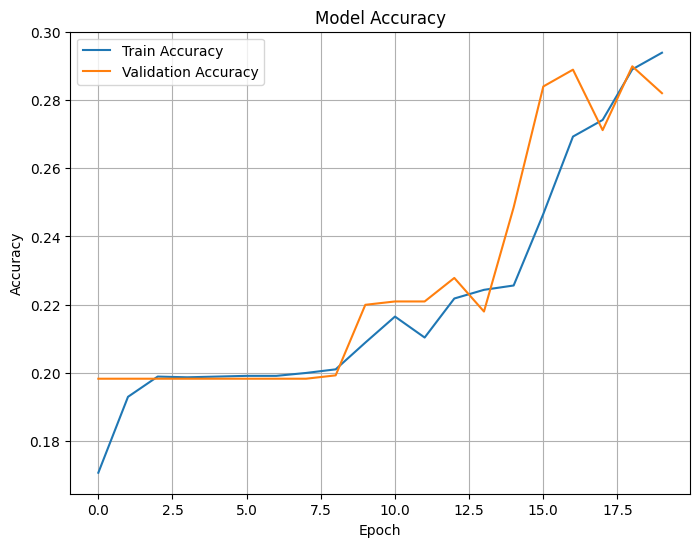

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


## **Confusion Matrix**

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step


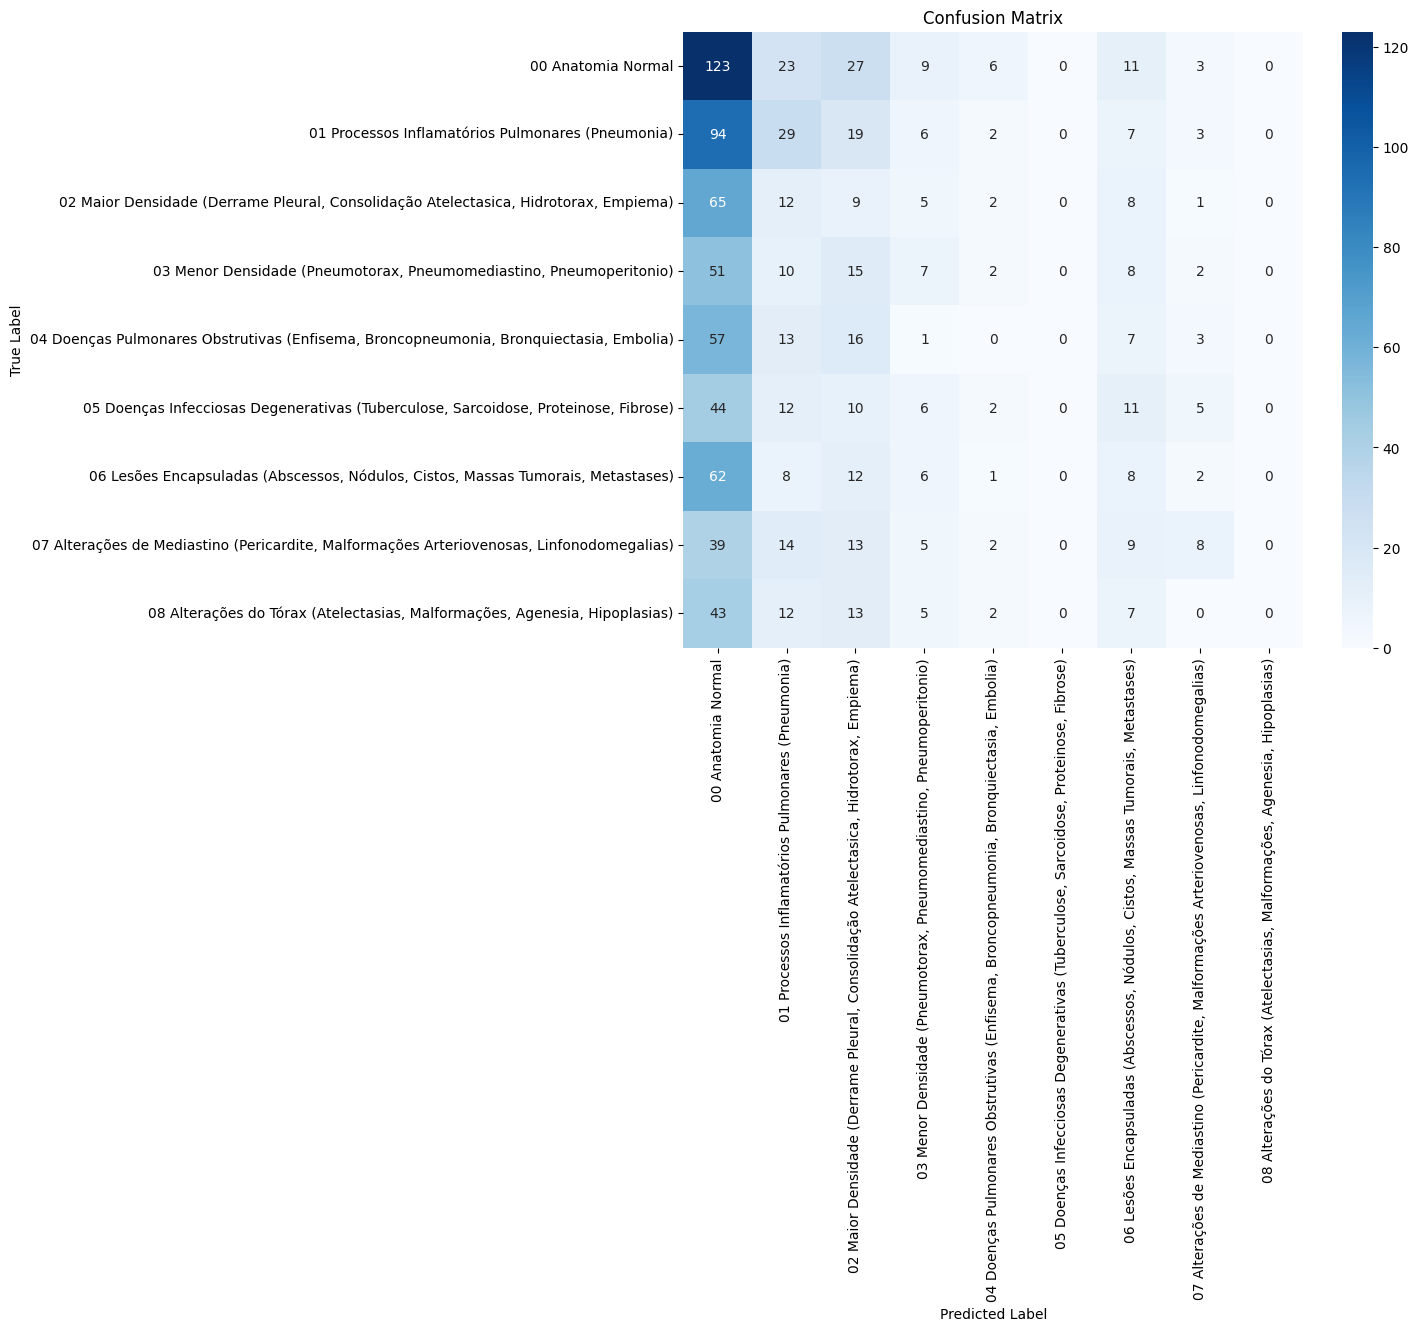

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



## **Classification Report**

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
                                                                                           precision    recall  f1-score   support

                                                                       00 Anatomia Normal       0.21      0.61      0.32       202
                                        01 Processos Inflamatórios Pulmonares (Pneumonia)       0.22      0.18      0.20       160
     02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)       0.07      0.09      0.08       102
                      03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)       0.14      0.07      0.10        95
   04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)       0.00      0.00      0.00        97
      05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)       0.00      0.00      0.00        90
         06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Interpetability**

## **grad_cam**


In [ ]:
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array, layer_name="conv2d"):
    # Create a model that maps the input image to the activations of the convolutional layer and final prediction
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(img_array)
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]  # Get the predicted class

    # Get gradients for the convolutional layer
    grads = tape.gradient(loss, conv_output)

    # Global Average Pooling for the gradients
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Multiply the activations with the pooled gradients
    conv_output = conv_output[0]
    heatmap = np.dot(conv_output, pooled_grads)

    # Apply ReLU to the heatmap to keep only positive values
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= np.max(heatmap)

    return heatmap

# Function to display the Grad-CAM heatmap
def display_grad_cam(img_path, model, target_size=(256, 256), layer_name="conv2d_15"):
    # Load the image
    img = image.load_img(img_path, target_size=target_size, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Convert to Tensor
    img_tensor = tf.convert_to_tensor(img_array)

    # Generate the Grad-CAM heatmap
    heatmap = grad_cam(model, img_tensor, layer_name)

    # Plot the heatmap
    plt.imshow(heatmap, cmap='viridis')
    plt.colorbar()
    plt.show()




In [ ]:
import os

# Find the first available class folder
test_dir = '/kaggle/working/xray_split/test'
classes = os.listdir(test_dir)
print(classes)

# Pick one class (for example the first one)
chosen_class = classes[0]
print(f"Chosen Class: {chosen_class}")

# Find an image inside that class
images_in_class = os.listdir(os.path.join(test_dir, chosen_class))
print(images_in_class)

# Pick an image
img_path = os.path.join(test_dir, chosen_class, images_in_class[0])
print(f"Final Image Path: {img_path}")


['06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)', '04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)', '05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)', '07 Alterações de Mediastino (Pericardite, Malformações Arteriovenosas, Linfonodomegalias)', '01 Processos Inflamatórios Pulmonares (Pneumonia)', '02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)', '03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)', '00 Anatomia Normal', '08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias)']
Chosen Class: 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)
['06 (4).jpg', '06 (239).jpeg', '06 (291).jpeg', '06 (574).jpeg', '06 (209).jpeg', '06 (191).jpeg', '06 (591).jpeg', '06 (111).jpeg', '06 (505).jpeg', '06 (134).jpeg', '06 (355).jpeg', '06 (27).jpeg', '06 (70).jpeg', '06 (55).jpeg', '06 (

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_105']]
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


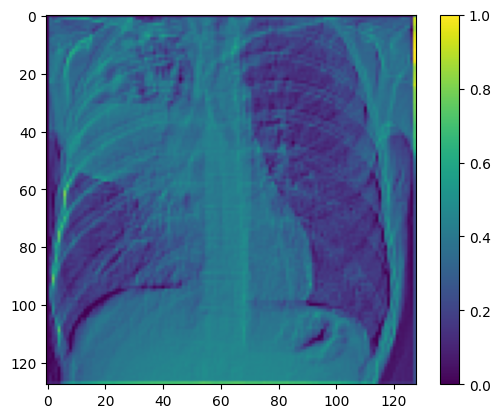

In [ ]:
# Example usage (replace with your own image path)
img_path = '/kaggle/working/xray_split/test/06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)/06 (4).jpg'


display_grad_cam(img_path, model, layer_name='conv2d_15')



## **LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4ee076bb6fb342d5ac6bf11f87b4e8d0d49deaa64cbfe6a109e146de80e9d965
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

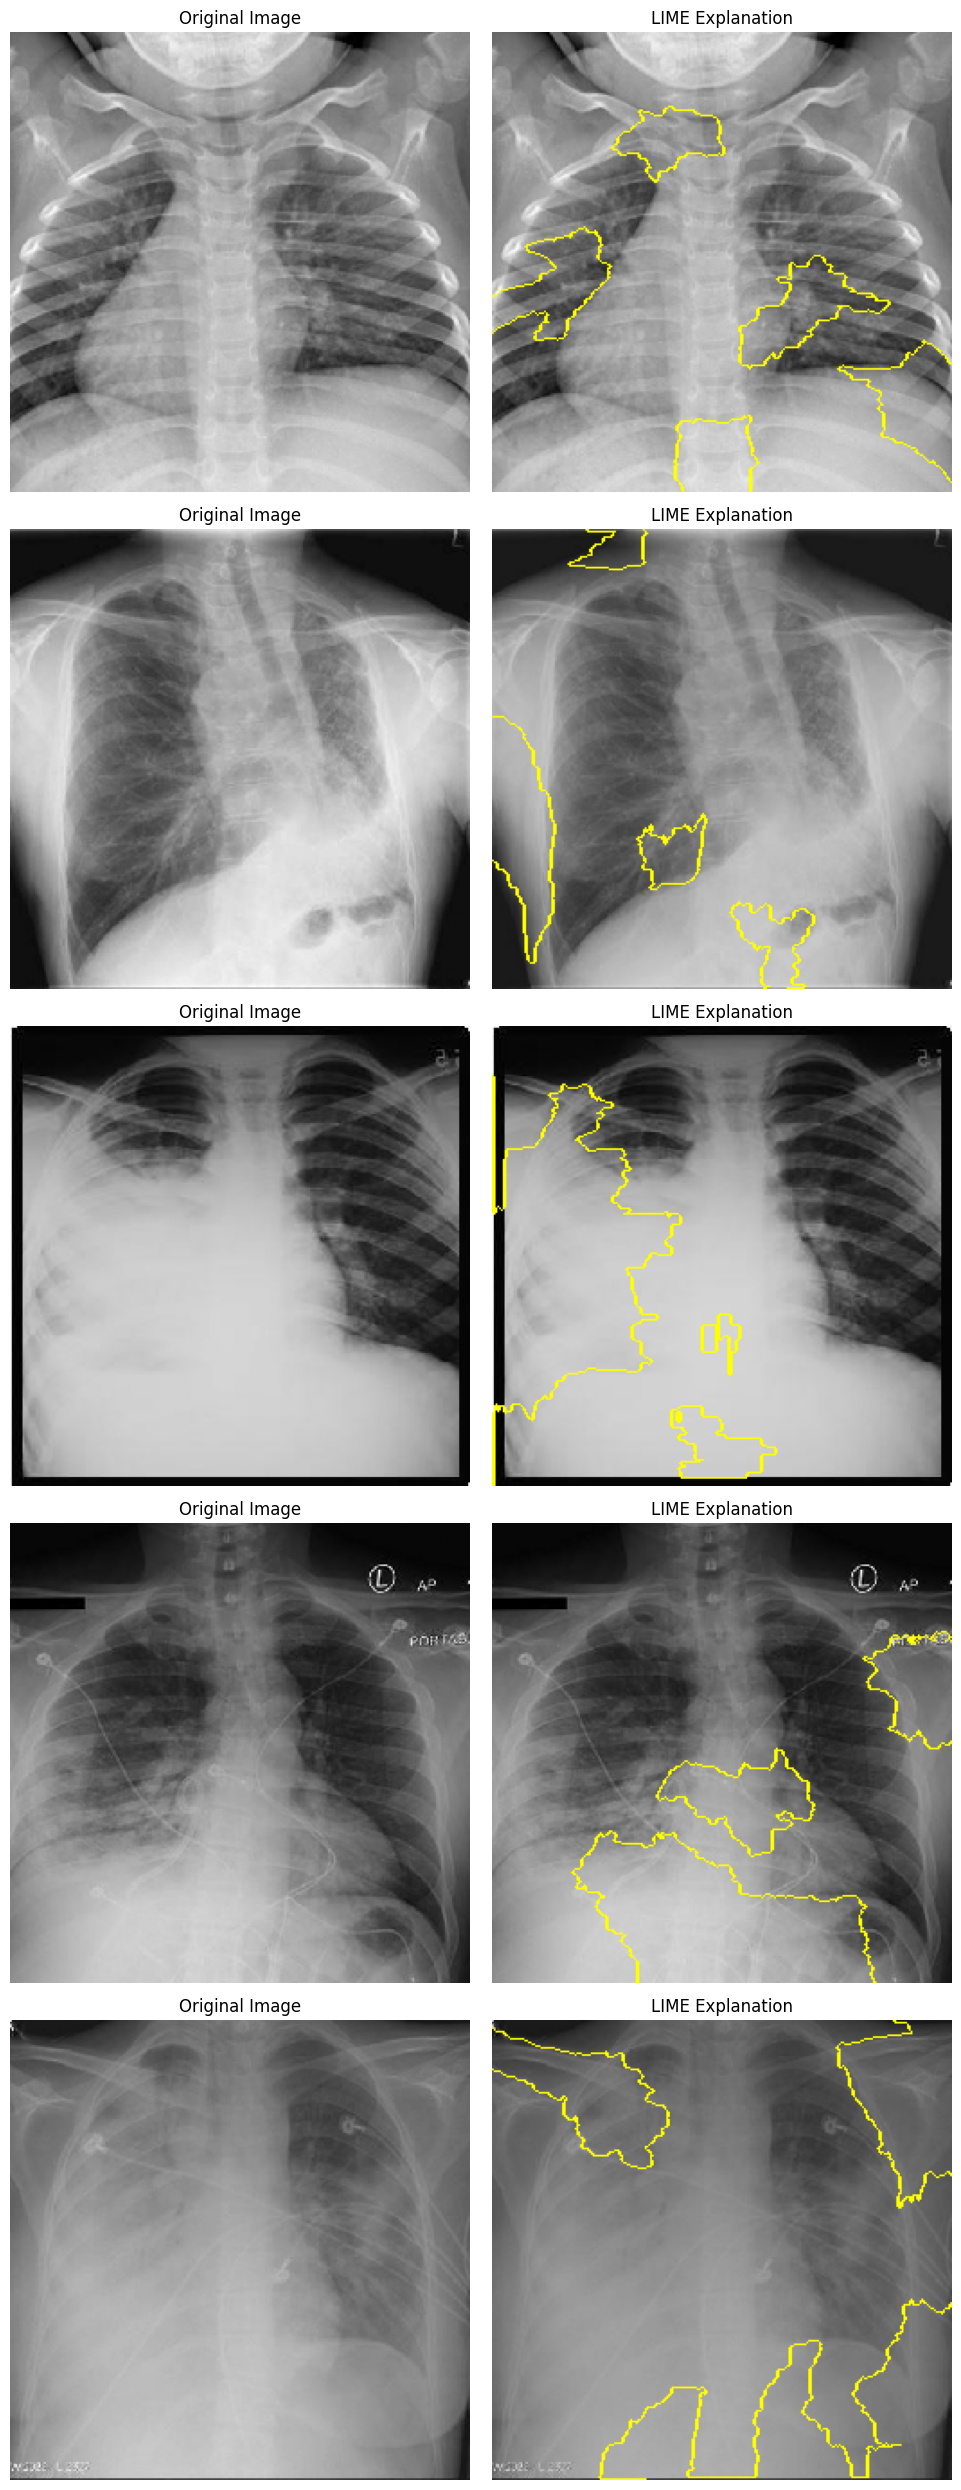

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Define the correct prediction function for LIME
def predict_fn(images_rgb):
    images_gray = np.dot(images_rgb[..., :3], [0.2989, 0.5870, 0.1140])  # RGB -> Grayscale
    images_gray = np.expand_dims(images_gray, axis=-1)
    return model.predict(images_gray)

# Initialize LIME
explainer = LimeImageExplainer()

# Get some samples
images, labels = next(test_generator)
images = images[:5]

fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))

for i, img_gray in enumerate(images):
    img_rgb = np.repeat(img_gray, 3, axis=2)  # Convert grayscale to fake RGB

    explanation = explainer.explain_instance(
        img_rgb,
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    axes[i, 0].imshow(img_gray.squeeze(), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mark_boundaries(temp, mask))
    axes[i, 1].set_title("LIME Explanation")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## **SHAP**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Disable GPU
# Then run your SHAP code

In [ ]:
img_path = '/kaggle/working/xray_split/test/06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases)/06 (4).jpg'

Model requires input shape: (None, 256, 256, 1)
Verified background shape: (1, 256, 256, 1)


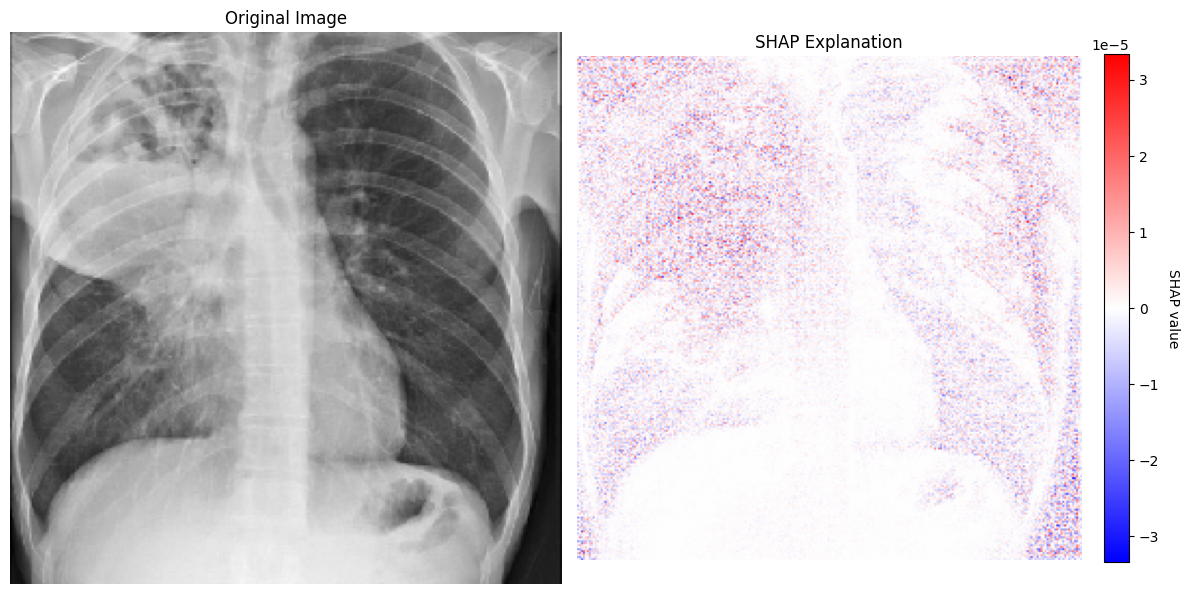

In [ ]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# ========== MEMORY AND GPU CONFIGURATION ==========
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
tf.keras.backend.clear_session()



# ========== MODEL INPUT VERIFICATION ==========
MODEL_INPUT_SIZE = model.input_shape[1:3]  # (256, 256)
print(f"Model requires input shape: (None, {MODEL_INPUT_SIZE[0]}, {MODEL_INPUT_SIZE[1]}, 1)")

# ========== DATA PREPARATION ==========
def load_and_preprocess(img_path):
    """Load and preprocess image with error handling"""
    try:
        img = load_img(img_path, target_size=MODEL_INPUT_SIZE, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        return np.expand_dims(img_array, axis=0)  # Shape: (1, 256, 256, 1)
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        return None

img_array = load_and_preprocess(img_path)
if img_array is None:
    raise ValueError("Failed to load input image")

# Prepare background data
background, _ = next(test_generator)
background = tf.image.resize(background, MODEL_INPUT_SIZE).numpy()[:1]  # Only 1 sample
print("Verified background shape:", background.shape)

# ========== SAFE PREDICTION WRAPPER ==========
def safe_predict(x):
    """Robust prediction function with memory handling"""
    try:
        with tf.device('/GPU:0'):
            return model.predict(x, verbose=0)
    except Exception as e:
        print(f"GPU prediction failed: {str(e)}")
        with tf.device('/CPU:0'):
            return model.predict(x, verbose=0)

# ========== SHAP IMPLEMENTATION ==========
def compute_shap_values():
    """Compute SHAP values with multiple fallback options"""

    # Option 1: GradientExplainer (most efficient)
    try:
        explainer = shap.GradientExplainer(model, background, batch_size=1)
        return explainer.shap_values(img_array, nsamples=10, ranked_outputs=1)
    except Exception as e:
        print(f"GradientExplainer failed: {str(e)}")


    try:
        def predict_wrapper(x):
            return safe_predict(x.reshape(-1, *MODEL_INPUT_SIZE, 1))

        explainer = shap.KernelExplainer(
            predict_wrapper,
            background.reshape(1, -1),
            nsamples=5  # Very low for memory
        )
        return explainer.shap_values(img_array.reshape(1, -1))
    except Exception as e:
        print(f"KernelExplainer failed: {str(e)}")

    # Option 3: Permutation explainer
    try:
        explainer = shap.PermutationExplainer(safe_predict, background)
        return explainer.shap_values(img_array)
    except Exception as e:
        print(f"All SHAP methods failed: {str(e)}")
        return None

shap_values = compute_shap_values()

if shap_values is None:
    raise RuntimeError("All SHAP computation methods failed")

# ========== ROBUST VISUALIZATION ==========




import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def visualize_shap_correctly(shap_values, original_img):
    """Produces SHAP visualization matching your reference image"""
    plt.figure(figsize=(12, 6))

    # Custom colormap matching your reference
    cmap = LinearSegmentedColormap.from_list('shap', ['blue', 'white', 'red'])

    # 1. Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img[0].squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # 2. Process SHAP values
    plt.subplot(1, 2, 2)

    # Extract SHAP values correctly
    if isinstance(shap_values, (tuple, list)):
        shap_img = shap_values[0]  # Take first output
    else:
        shap_img = shap_values

    # Convert to proper 2D format
    shap_img = np.array(shap_img).squeeze()
    if shap_img.ndim > 2:
        shap_img = shap_img[0]  # Take first channel if multiple exist

    # 3. Plot with proper color scaling
    vmax = np.max(np.abs(shap_img))
    im = plt.imshow(shap_img, cmap=cmap, vmin=-vmax, vmax=vmax)

    # Add colorbar with exact formatting from your reference
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('SHAP value', rotation=270, labelpad=15)
    cbar.formatter.set_powerlimits((0, 0))  # Force scientific notation for small values

    plt.title("SHAP Explanation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
visualize_shap_correctly(shap_values, img_array)

## **Saliency Map**

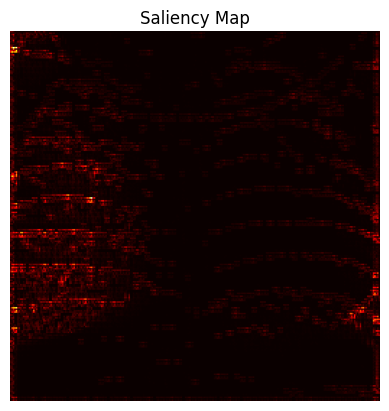

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_saliency_map(model, img_array):
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_class = preds[:, tf.argmax(preds[0])]

    grads = tape.gradient(top_class, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    plt.show()

# Example
img, _ = next(test_generator)
img = img[0:1]  # Pick 1 sample

plot_saliency_map(model, img)


## **Integrated Gradients**

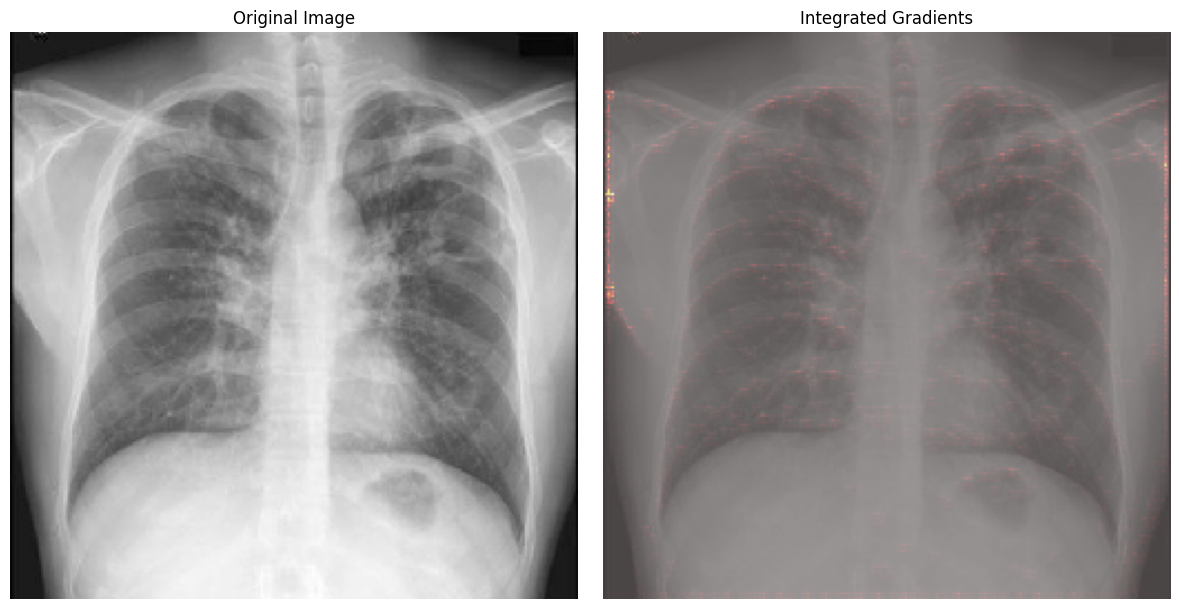

In [ ]:
def integrated_gradients(model, img_array, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros(img_array.shape).astype(np.float32)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline_tensor = tf.convert_to_tensor(baseline, dtype=tf.float32)

    interpolated_images = [baseline_tensor + (float(i)/steps)*(img_tensor-baseline_tensor) for i in range(steps + 1)]
    grads = []
    for img in interpolated_images:
        with tf.GradientTape() as tape:
            tape.watch(img)
            pred = model(img)
            top_class = pred[:, tf.argmax(pred[0])]
        grad = tape.gradient(top_class, img)
        grads.append(grad.numpy())

    avg_grads = np.mean(grads, axis=0)
    integrated_grads = (img_tensor - baseline_tensor) * avg_grads
    return integrated_grads.numpy()

# Example
img, _ = next(test_generator)
img = img[0:1]

# Compute
int_grads = integrated_gradients(model, img)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original
ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Integrated Gradients Overlay
ax[1].imshow(img.squeeze(), cmap='gray', alpha=0.6)
ax[1].imshow(np.abs(int_grads.squeeze()), cmap='hot', alpha=0.4)
ax[1].set_title('Integrated Gradients')
ax[1].axis('off')

plt.tight_layout()
plt.show()


## **Surrogate Model (Global interpretation)**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU to use CPU


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

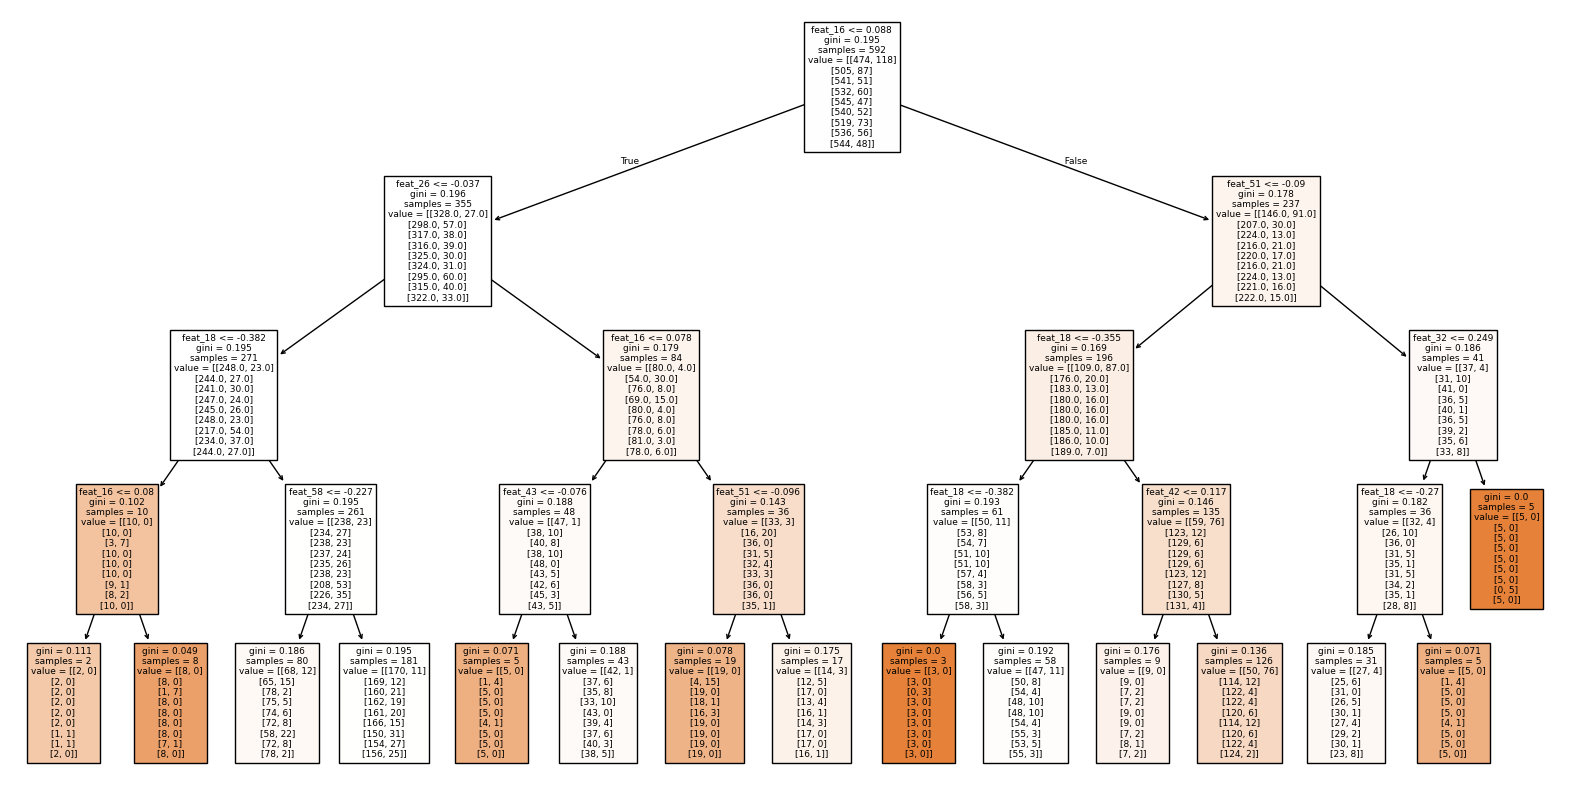

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Reduced batch size for extracting features and computing SHAP values
def extract_features(model, generator, batch_size=8):
    features = []
    labels = []

    # Iterate over the generator and extract features in smaller batches
    for i in range(0, len(generator), batch_size):
        batch_images, batch_labels = next(generator)
        batch_features = model.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Feature extraction from the intermediate layer for SHAP and Decision Tree
feature_extractor = models.Model(inputs=model.input, outputs=model.get_layer('global_average_pooling1d').output)
features, labels = extract_features(feature_extractor, train_generator, batch_size=8)

# Train a surrogate model (Decision Tree) with reduced feature set
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(features, labels)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=[f"feat_{i}" for i in range(features.shape[1])])
plt.show()



## **Global Interpretability Methods (Explaining Overall Model Behavior)**

## **grad_cam_plus_plus**

In [ ]:
# Reduce batch size
batch_size = 8  # Use smaller batch size for memory efficiency

# Reduce input size
img_size = (128, 128)  # Smaller input size

# Update the generator accordingly
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/xray_split/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 4712 images belonging to 9 classes.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam_plus_plus(model, img_array, layer_name='conv2d'):
    # Ensure that the model is executed on the image input
    model(img_array)  # Ensures all layers are initialized

    # Extract outputs from the specified layer
    last_conv_layer = model.get_layer(layer_name)
    grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape(persistent=True) as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]  # Use class with highest predicted probability

    # Capture the gradient for the output predicted class
    grads = tape.gradient(loss, conv_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    # Apply ReLU to remove negative values
    cam = tf.maximum(cam, 0)

    # Normalize the heatmap
    heatmap = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam))

    # Get the predicted class index
    class_index = tf.argmax(predictions[0]).numpy()

    return heatmap.numpy(), class_index





In [ ]:
def aggregate_grad_cam(model, generator, num_images=10):
    heatmaps = []


    for i in range(num_images):
        img, _ = next(generator)  # Get one batch of images from the generator


        heatmap, _ = grad_cam_plus_plus(model, img, 'conv2d')  #  correct layer name
        heatmaps.append(heatmap)  # Append individual heatmap to the list

    # Compute the average heatmap across all images processed
    avg_heatmap = np.mean(heatmaps, axis=0)

    # Plot the average Grad-CAM heatmap
    plt.imshow(avg_heatmap, cmap='jet')
    plt.axis('off')
    plt.title('Average Grad-CAM across images')
    plt.show()



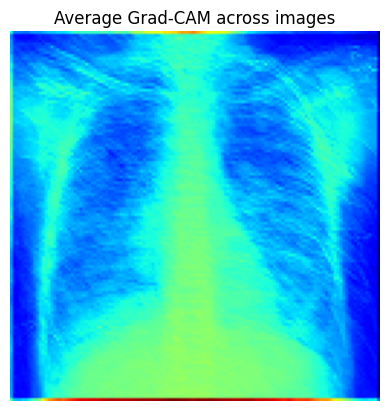

In [ ]:
# Run Grad-CAM for a subset of images from the test generator
aggregate_grad_cam(model, test_generator, num_images=10)
